# Plot comparisons for Multi-stage Hypersolvers

In [1]:
%load_ext autoreload
%autoreload 2

import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import pi as π

import sys; sys.path.append(2*'../') # go n dirs back
from src import *

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler
from torchdyn.numerics.solvers import Midpoint, SolverTemplate
from torchdyn.numerics.hypersolvers import HyperMidpoint

device = 'cpu' # feel free to change!

In [11]:
class MultiStageHypersolver(SolverTemplate):
    """
    Explicit multistage ODE stepper: inner stage is a vector field corrector
    while the outer stage is a residual approximator of the ODE solver
    """
    def __init__(self, inner_stage: nn.Module, outer_stage: nn.Module,
                       base_solver=Midpoint, dtype=torch.float32):
        super().__init__(order=base_solver().order)
        self.dtype = dtype
        self.stepping_class = 'fixed'
        self.base_solver = base_solver
        self.inner_stage = inner_stage
        self.outer_stage = outer_stage

    def step(self, f, x, t, dt, k1=None):
        # Correct vector field with inner stage and propagate
        self.vector_field = f
        _, _x_sol, _ = self.base_solver().step(self.corrected_vector_field, x, t, dt, k1=k1)
        # Residual correction with outer stage
        x_sol = _x_sol + dt**self.base_solver().order * self.outer_stage(t, f(t, x))
        return _, x_sol, _ 

    def corrected_vector_field(self, t, x):
        return self.vector_field(t, x) + self.inner_stage(t, x)


class HyperNetwork(nn.Module):
    """Simple hypernetwork using as input the current state, vector field and controller"""
    def __init__(self, net, sys):
        super().__init__()
        self.net = net
        self.sys = sys
    
    def forward(self, t, x):
        xfu = torch.cat([x, self.sys.cur_f, self.sys.cur_u], -1)
        return self.net(xfu)
        

In [12]:
# System we have
sys = CartPole(RandConstController())

# Real system
sys_nominal = CartPole(RandConstController())
sys_nominal.frictioncart = 0.1
sys_nominal.frictionpole = 0.03


# Initial distribution
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
u_min, u_max = -30, 30


## Plotting and comparisons: Hypersolver vs others

In [13]:
from math import pi as π

# Sample and plot some trajectories
# We limit distribution and controllers since in reality we don't go out of the [-2pi, 2pi] bounds
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
x0 = init_dist.sample((100000,)).to(device)
val = torch.Tensor(100000, 1).uniform_(-10,10).to(device) 
sys.u.u0 = val
sys_nominal.u.u0 = val
dt = 0.05

Tf = 1
t_span = torch.linspace(0, Tf, int(Tf/dt)+1).to(device)

In [14]:
# Error analysis
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def plot_trajs_errors():
    fig, axs = plt.subplots(1, 4, figsize=(11,3))
    # fig = plt.figure(figsize=(16,5))
    # ax = fig.add_subplot(1,2,1)
    titles = ['Position', 'Velocity', 'Angular Position', 'Angular Velocity']

    alpha = .1
    for i in range(4):
        axs[i].plot(t_span, mean_hyper[:,i], 'tab:orange', label='Multistage Hypersolver (inaccurate model)')
        axs[i].plot(t_span, mean_mp_wrong[:,i], 'tab:blue', label='Midpoint (inaccurate model)')
        axs[i].plot(t_span, mean_euler[:,i], 'tab:red', label='Euler (nominal model)')
        axs[i].plot(t_span, mean_mp[:,i], 'tab:green', label='Midpoint (nominal model)')

        axs[i].set_yscale('log')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(f'Time $[s]$', labelpad=-4)
        axs[i].set_ylabel(f'SMAPE')
        axs[i].set_xticks([0, 1.0])
        axs[i].set_xlim(0, 1)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.1))
    plt.tight_layout()

    fig.savefig('media/error_propagation_multistage.pdf',  bbox_inches = 'tight')

    import tikzplotlib
    tikzplotlib.save("media/error_propagation_multistage.tex")

def load_multistage(sys, folder='saved_models/hs_multistage_joint_snake.pt'):
    multistagehs = torch.load(folder)
    inner_stage_net = multistagehs.inner_stage.net 
    outer_stage_net = multistagehs.outer_stage.net 
    inner_stage_hypernet = HyperNetwork(inner_stage_net, sys)
    outer_stage_hypernet = HyperNetwork(outer_stage_net, sys)
    multistagehs.inner_stage = inner_stage_hypernet
    multistagehs.outer_stage = outer_stage_hypernet
    # print(multistagehs)
    return multistagehs

/home/botu/anaconda3/lib/python3.8/site-packages/torchdyn/numerics/odeint.py:82: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


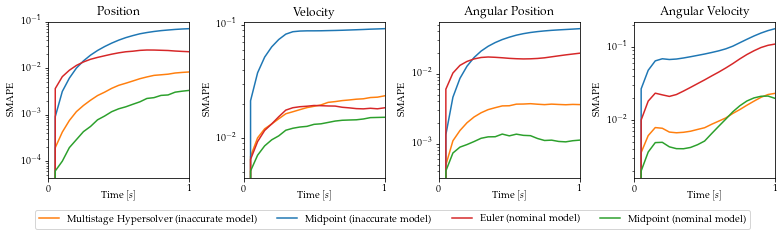

In [15]:
with torch.no_grad():
    _, traj_euler = odeint(sys_nominal._dynamics, x0, t_span, solver='euler')
    _hs = load_multistage(sys)
    _, traj_hyper = odeint(sys._dynamics, x0, t_span, solver=_hs)
    _, traj_mp = odeint(sys_nominal._dynamics, x0, t_span, solver='midpoint')
    _, traj_mp_wrong = odeint(sys._dynamics, x0, t_span, solver='midpoint')
    _, traj_gt = odeint(sys_nominal._dynamics, x0, t_span, solver='rk4', atol=1e-4, rtol=1e-4)
    traj_euler = traj_euler.detach().cpu(); traj_hyper = traj_hyper.detach().cpu(); traj_gt = traj_gt.detach().cpu()
    traj_mp = traj_mp.detach().cpu(); traj_mp_wrong = traj_mp_wrong.detach().cpu()
    t_span = t_span.cpu()

err_euler = smape(traj_gt, traj_euler).detach().cpu()
err_hyper = smape(traj_gt, traj_hyper).detach().cpu()
err_mp  = smape(traj_gt, traj_mp).detach().cpu()
err_mp_wrong = smape(traj_gt, traj_mp_wrong).detach().cpu()
mean_euler, std_euler = err_euler.mean(1), err_euler.std(1)
mean_hyper, std_hyper = err_hyper.mean(1), err_hyper.std(1)
mean_mp, std_mp = err_mp.mean(1), err_mp.std(1)
mean_mp_wrong, std_mp_wrong = err_mp_wrong.mean(1), err_mp_wrong.std(1)


plot_trajs_errors()

## Hypersolver ablation study

In [39]:
def load_multistage(sys, folder='saved_models/hs_multistage_joint_snake.pt'):
    multistagehs = torch.load(folder)
    inner_stage_net = multistagehs.inner_stage.net 
    outer_stage_net = multistagehs.outer_stage.net 
    inner_stage_hypernet = HyperNetwork(inner_stage_net, sys)
    outer_stage_hypernet = HyperNetwork(outer_stage_net, sys)
    multistagehs.inner_stage = inner_stage_hypernet
    multistagehs.outer_stage = outer_stage_hypernet
    return multistagehs

# Ablation: set network to 0
class Dummy(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
    
    def forward(self, x):
        return 0

dummy_stage = HyperNetwork(Dummy(None), sys)

hs_multistage_joint_training = load_multistage(sys, folder='saved_models/hs_multistage_joint_snake.pt')
hs_multistage_separated_training = load_multistage(sys, folder='saved_models/hs_multistage_separated_snake.pt')
residual_dynamics = load_multistage(sys, folder='saved_models/residual_dynamics_solver.pt')
hs_multistage_joint_training_no_inner = load_multistage(sys, folder='saved_models/hs_multistage_joint_snake.pt')
hs_multistage_joint_training_no_inner.inner_stage = dummy_stage
hs_multistage_joint_training_no_outer = load_multistage(sys, folder='saved_models/hs_multistage_joint_snake.pt')
hs_multistage_joint_training_no_outer.outer_stage = dummy_stage

In [83]:
from math import pi as π

# Sample and plot some trajectories
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
x0 = init_dist.sample((100000,)).to(device)
val = torch.Tensor(100000, 1).uniform_(-30,30).to(device)
sys.u.u0 = val
sys_nominal.u.u0 = val

# just one step trajectory for error calculation
t_span = torch.linspace(0, dt, 2).to(device)

with torch.no_grad():
    # Ground truth
    _, traj_gt = odeint(sys_nominal._dynamics, x0, t_span, solver='rk4') # TODO substitute 

    # Classical solvers
    _, traj_mp_wrong = odeint(sys._dynamics, x0, t_span, solver='midpoint')
    _, traj_eu = odeint(sys_nominal._dynamics, x0, t_span, solver='euler')
    _, traj_mp = odeint(sys_nominal._dynamics, x0, t_span, solver='midpoint')

    # Hypersolvers and ablations
    _, traj_hs_multistage_joint_training = odeint(sys._dynamics, x0, t_span, solver=hs_multistage_joint_training)
    _, traj_hs_multistage_separated_training = odeint(sys._dynamics, x0, t_span, solver=hs_multistage_separated_training)
    _, traj_residual_dynamics = odeint(sys._dynamics, x0, t_span, solver=residual_dynamics)
    _, traj_hs_multistage_joint_training_no_inner = odeint(sys._dynamics, x0, t_span, solver=hs_multistage_joint_training_no_inner)
    _, traj_hs_multistage_joint_training_no_outer = odeint(sys._dynamics, x0, t_span, solver=hs_multistage_joint_training_no_outer)

    t_span = t_span.cpu()

In [84]:
def terminal_mae(y, y_pred, dim=1):
    """Compute MAE along dimension"""
    mae = ((y[-1] - y_pred[-1]).abs()).mean(dim)
    return mae

mae_mp_wrong = terminal_mae(traj_gt, traj_mp_wrong)
mae_eu= terminal_mae(traj_gt, traj_eu)
mae_mp = terminal_mae(traj_gt, traj_mp)

mae_hs_joint = terminal_mae(traj_gt, traj_hs_multistage_joint_training)
mae_hs_separate = terminal_mae(traj_gt, traj_hs_multistage_separated_training)
mae_resdyn = terminal_mae(traj_gt, traj_residual_dynamics)
mae_hs_joint_no_in = terminal_mae(traj_gt, traj_hs_multistage_joint_training_no_inner)
mae_hs_joint_no_out = terminal_mae(traj_gt, traj_hs_multistage_joint_training_no_outer)

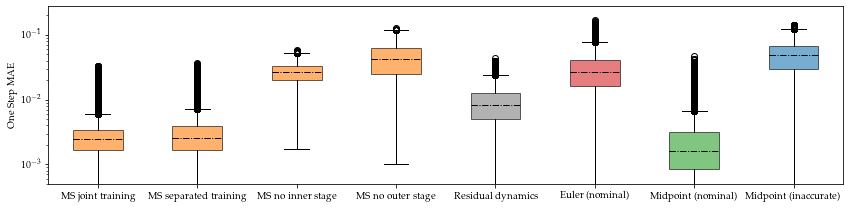

In [106]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

colors = ['tab:orange', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:grey', 'tab:red', 'tab:green', 'tab:blue']
labels = ['MS joint training', 'MS separated training', 'MS no inner stage', 'MS no outer stage', 'Residual dynamics', 'Euler (nominal)', 'Midpoint (nominal)', 'Midpoint (inaccurate)']
plots = [mae_hs_joint, mae_hs_separate, mae_hs_joint_no_in, mae_hs_joint_no_out,  mae_resdyn, mae_eu, mae_mp, mae_mp_wrong]

fig, ax = plt.subplots(1,1, figsize=(12,3))

# heights = [h.mean() for h in plots]
# bp = ax.bar(labels, heights,
#                 patch_artist=True, labels=labels)

bp = ax.boxplot(plots,
                patch_artist=True, labels=labels)

for b, m, c in zip(bp['boxes'], bp['medians'], colors):
    b.set_facecolor(c)
    b.set_alpha(0.6)
    m.set(color='black', linestyle='-.')
ax.set_yscale('log')
ax.set_ylim(5e-4)
ax.set_ylabel('One Step MAE')
plt.tight_layout()

# Saving
import tikzplotlib
fig.savefig('media/multistage_mae.pdf',  bbox_inches = 'tight')
tikzplotlib.save("media/multistage_mae.tex")